In [281]:
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
import sklearn.decomposition as dec
import sklearn.model_selection as sel
import sklearn.manifold as mnf
import sklearn.naive_bayes as nb
import sklearn.neighbors as ngb
import sklearn.tree as tr
import sklearn.ensemble as ens
import sklearn.cluster as cl
import sklearn.mixture as mx
import sklearn.metrics as mtx
import umap

# Formule utili: #

## Generazione dati ##

Le funzioni che conosciamo per generare i dati sono 3:
1. **funzione generazione [gaussiana](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html)**
2. **funzione generazione [uniforme](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)**
3. **funzione a [griglia](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)**

#### 1. Funzione gaussiana ####
Prende in input un array con i valori medi sulle varie dimensioni e la matrice di covarianza. Se al posto di una matrice di covarianza gli si da un array lo trasforma in una matrice di covarianza diagonale (dati scorrelati).  
N rappresenta quanti punti sampla

In [282]:

def gaussian(mu=0.,sigma=1.,N=1):
    if hasattr(mu, "__len__"):
        D=len(mu)
    else:
        mu=np.array([mu])
        D=1
    if not hasattr(sigma,"__len__"):
        sigma=np.array([sigma])
    
    if type(mu) is not np.ndarray:
        mu=np.array(mu)
    if type(sigma) is not np.ndarray:
        sigma=np.array(sigma)
    if sigma.size==D:
        sigma=np.diag(sigma)
    
    return np.random.multivariate_normal(mu,sigma**2,N)


#### 2. Funzione uniforme ####
Prende in input due liste con i minimi sulle diverse dimensioni ed una con i massimi.  
N rappresenta quanti punti sampla

In [283]:
def uniform(mins=0.,maxs=1.,N=1):
    if hasattr(mins, "__len__"):
        D=len(mins)
        return np.random.uniform(mins,maxs,size=(N,D))
    else:
        D=1
        return np.random.uniform(mins,maxs,size=(N,D)).T[0]

#### 3. Funzione a griglia ####
Prende in input due liste con i minimi sulle diverse dimensioni ed una con i massimi.  
Poi e' presente un flag per segnare se *dn* indica in quante parti dividere gli intervalli oppure la distanza tra i punti

In [284]:
def grid(min, max,dn, ndivisions=True):
    xD=[]
    for i in range(len(min)):
        if ndivisions:
            xD.append(np.linspace(min[i],max[i],dn))
        else:
            xD.append(np.arange(min[i],max[i],dn))
    xD=tuple(xD)
    return np.meshgrid(*xD)


## 
---
Dati utili per dimostrare il funzionamento delle funzioni

In [285]:
n_feautures1=2
n_feautures0=30
mu=uniform(-1,1,n_feautures0)
sigma=uniform(0,5,n_feautures0)
sigma=np.diag(sigma)
sigma[n_feautures0//2][n_feautures0//3]=1.
sigma[n_feautures0//3][n_feautures0//2]=1.
sigma[n_feautures0//2][n_feautures0//4]=3.
sigma[n_feautures0//4][n_feautures0//2]=3.
sigma[n_feautures0//5][n_feautures0//6]=2.5
sigma[n_feautures0//6][n_feautures0//5]=2.5
DATA=gaussian(mu,sigma,N=20000)
LABEL=np.random.randint(0,5,size=20000)
REGR=np.sin(np.array([np.sum(DATA,axis=1),np.sum(-DATA*2,axis=1)]).T)

/tmp/ipykernel_121389/1505875170.py:17: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu,sigma**2,N)


## 
---

## Manipolazione dati

#### [Dividere tra train,validation e test](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):
Questo serve per dividere il sample i parti che posso usare per scegliere gli iperparametri o valutare la bonta' del mio apprendimento

In [286]:
train,test,LABtrain,LABtest=sel.train_test_split(DATA,LABEL,test_size=0.3,shuffle=True) #test 30% train 70%

#### Iportanza delle feautures
Se si vuole conoscere l'importanza delle feautures e quantificare una incertezza si puo' utilizzare la `RandomForest` *(vedi  `"Apprendimento supervisionato->Classificazione->RandomForest"`)*


## Riduzione dimensionale ##

Le funzioni che conosciamo per ridurre le dimensioni di un problema sono 3:

1. **funzione [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)**
2. **funzione [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)**
3. **funzione [UMAP](https://umap-learn.readthedocs.io/en/latest/parameters.html)**

#### 1. Funzione PCA ####
Questa funzione permette fissato il numero di features che si vogliono considerare.  
E' lineare ed e' invertibile infatti si puo' ottenere anche la matrice di rotazione  
>**NB.**  
>**prima di utilizzarla e' bene normalizzare i dati con:**  
>`(DATA-DATA.mean())/DATA.std()`

In [287]:
redModel=dec.PCA(n_components=n_feautures1)
redModel.fit(DATA)
DATAred=redModel.transform(DATA)

[7.32808288 7.14952737]


Text(0.5, 1.0, 'PCA reduction')

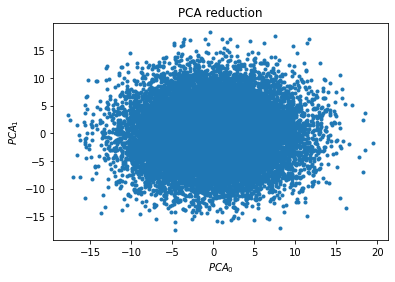

In [288]:
print(redModel.explained_variance_ratio_*100)
DATAred=DATAred.T
plt.plot(DATAred[0],DATAred[1],ls="",marker=".")
plt.xlabel(r"$PCA_0$")
plt.ylabel(r"$PCA_1$")
plt.title("PCA reduction")

> Altre possibili cose utili per il PCA sono:  
>- modi per valutare lo score:  
>   - `redModel.explained_variance_` che ti dice quanta varianza spiegano le tue nuove feautures  
>   - `redModel.explained_variance_ratio_`  che ti dice in che percentuale di varianza spiegano
>- altre robe:
>   - `redModel.inverse_transform(DATAred)` che dalle variabili ridotte ti restituisce le feautures originali

#### 2. Funzione tSNE ####
Questa funzione permette fissato il numero di features che si vogliono considerare.  
Non e' lineare  
>**NB.**  
>**Questa funzione e' molto lenta se il dataset e' ampio**

>Sono presenti inoltre due parametri da scegliere e che bisonga provare:
>- `perplexity` tra 5 e 50 circa, bisogna scegliere quella che fornisce la migliore rappresentazione
>- `n_iter` almeno 250 raccomandato, il prof. ha messo 300

In [289]:
per=40 #perplexity
ni=300 #n_iterations
redModel=mnf.TSNE(n_components=n_feautures1,perplexity=per,n_iter=ni)
DATAred=redModel.fit_transform(DATA) #non esiste il transform da solo, ma esiste il fit da solo

/home/giuly/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/giuly/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'tSNE reduction')

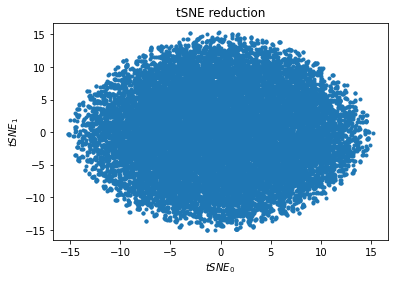

In [290]:
DATAred=DATAred.T
plt.plot(DATAred[0],DATAred[1],ls="",marker=".")
plt.xlabel(r"$tSNE_0$")
plt.ylabel(r"$tSNE_1$")
plt.title("tSNE reduction")

#### 3. Funzione UMAP ####
Questa funzione dovrebbe mantenere la struttura globale e locale del mainfold. Non e' lineare.

In [291]:
redModel=umap.UMAP()
redModel.fit(DATA,LABEL)
DATAred=redModel.transform(DATA)


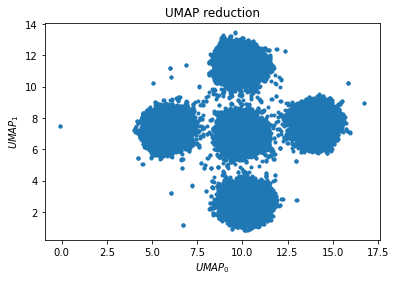

In [292]:
DATAred=DATAred.T
plt.title("UMAP reduction")
plt.xlabel('$UMAP_0$')
plt.ylabel('$UMAP_1$')
plt.plot(DATAred[0],DATAred[1],ls="",marker=".")

## Apprendimento supervisionato ##


### Classificazione: ###
Gli algoritmi che conosciamo per la classificazione sono 4:
1. **metodo [Naive-Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) in particolare con dati distribuiti gaussianamente, quindi [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)**
2. **funzione [k-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)**
3. **funzione [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)**
4. **funzione [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)**

> Lo `score` di questi modelli e' l'accuracy

> Per valutare quanto il modello e' buono nella predizione si puo' utilizzare `predict` e poi analizzare la `confusion_matrix`

#### 1. GaussianNB
Questo algoritmo lo abbiamo usato senza parametri ed e molto buono, 
>**NB.**  
>**Non funziona se le variabili sono correlate, inoltre puo' risultare lento.**

In [293]:
model=nb.GaussianNB()
model.fit(DATA,LABEL)



GaussianNB()

In [294]:
print(model.score(DATA,LABEL))
predict=model.predict(DATA)
print(mtx.confusion_matrix(LABEL,predictnormalize='true'))

0.22745


TypeError: confusion_matrix() got an unexpected keyword argument 'predictnormalize'

#### 2. k-NN
Questo algoritmo e' veloce e esiste nella versione di regressione
> E' presente un iperparametro da scegliere e che bisonga provare:
>- `k` tra 1 e 50 circa, e' il numero dei primi vicini di cui controlla il label quando allena il modello. Un `k` basso e' sensibile agli outlayers mentre un `k` alto e' lento e rischia di non essere efficace.

In [ ]:
k=10
model=ngb.KNeighborsClassifier(k)
model.fit(DATA,LABEL)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
print(model.score(DATA,LABEL))
predict=model.predict(DATA)
print(mtx.confusion_matrix(LABEL,predictnormalize='true'))

0.37285
[[0.35543175 0.15914578 0.16898793 0.15766017 0.15877437]
 [0.13637314 0.36916963 0.16230914 0.16921146 0.16293662]
 [0.14004848 0.13735524 0.37355238 0.17532992 0.17371398]
 [0.14436519 0.14807418 0.15378031 0.37489301 0.1788873 ]
 [0.14984709 0.14411315 0.14908257 0.14525994 0.41169725]]


#### 3. DecisionTree
Questo algoritmo e' veloce e esiste nella versione di regressione
> E' presente un iperparametro da scegliere e che bisonga provare:
>- `max_depth` tra 1 e 10 circa, e' la profondita' dell'albero. Un `max_deph` basso e' non rende il modello significativo mentre se e' troppo alto overfitta.

In [ ]:
mxDPH=5
model=tr.DecisionTreeClassifier(max_depth=mxDPH)
model.fit(DATA,LABEL)

DecisionTreeClassifier(max_depth=5)

In [ ]:
print(model.score(DATA,LABEL))
predict=model.predict(DATA)
print(mtx.confusion_matrix(LABEL,predictnormalize='true'))

0.2114
[[0.20464272 0.1988069  0.19459214 0.20114123 0.20081701]
 [0.18571429 0.34285714 0.18928571 0.12857143 0.15357143]
 [0.17736033 0.2063918  0.22102952 0.20029275 0.19492559]
 [0.17391304 0.10869565 0.10869565 0.58695652 0.02173913]
 [0.26797386 0.09803922 0.24183007 0.11111111 0.28104575]]


#### 4. RandomForest
Questo algoritmo consiste in un ensamble di altri modelli, nel caso specifico di (e come lo abbiamo utilizzato noi) di alberi. Il risultato si tratta di una media di diversi alberi. Esiste nella versione di regressione
> Sono presenti 3 iperparametri da scegliere e che bisonga provare:
>- `max_depth` e' la massima profondita' degli alberi che costituiscono la foresta
>- `min_samples_split` governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero
>- `n_estimators` e' il numero degli alberi nella foresta

In [327]:
nTree=30
leafsz=10
mxDPH=5
model=ens.RandomForestClassifier(n_estimators=nTree,
                                min_samples_split=leafsz,
                                max_depth=mxDPH,
                                oob_score=True,
                                warm_start=True)
model.fit(DATA,LABEL)


/home/giuly/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=30,
                       oob_score=True, warm_start=True)

In [329]:
print(model.score(DATA,LABEL))
print(model.oob_score_)
predict=model.predict(DATA)
print(mtx.confusion_matrix(LABEL,predict,normalize='true'))

0.2919
0.20005
[[0.45794393 0.05459911 0.33817019 0.06689621 0.08239056]
 [0.33062262 0.15628971 0.35247776 0.06175349 0.09885642]
 [0.28897618 0.05548736 0.49275718 0.06432605 0.09845323]
 [0.32422172 0.06150342 0.38116932 0.13211845 0.10098709]
 [0.32679245 0.05534591 0.34264151 0.06591195 0.20930818]]


> Altre possibili cose utili per la RandomForest sono:  
>- modi per valutare lo score:  
>   - `model.oob_score_` va a calcolare la media dello score dei vari alberi, ma utilizzando per ogni albero una parte di dati che non ha utilizzato per trainalo. Questa metrica e' accessibile soltanto se si chiama la Forest con il parametro `oob_score` impostato su `True`  
>- aumentare la velocita' nel generare foreste multiple:
>   - `warm_start`  e' un parametro che se impostato su `True` e se si fanno piu' foreste con un diverso numero di alberi (`n_estimators`) non ricrea la foresta da capo, ma pianta piu' alberi in quella vecchia

##### _**RandomForest per classificare l'importanza delle feautures:**_
Il modello RandomForest puo' essere anche utilizzato per quantificare e ordinare l'importanza delle feautures di un dataset per farlo si fa una media dell'importanza delle feutures quantificata negli alberi per poterlo fare si fa uso del metodo `model.feauture_importances` e del metodo `model.estimators`:

In [330]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

### Regressione: ###
Conosciamo 3 algoritmi di regressione:
1. **funzione [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)**
2. **funzione [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)**
3. **funzione [k-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)**

> In questi algoritmi il parametro `criterion` e' il metodo con cui si calcola la `loss function` mentre l'algorimo apprende. Noi usiamo sempre l'errore quadratico medio, ovvero la distanza euclidea `"squared_error"`

> Lo `score` di questi modelli e' $R^2$ che sarebbe $\left(1-\frac{u}{v}\right)$ in cui $u$ e' $\sum \left(y^{predetto}_i - y^{vero}_i\right)^2$ e $v$ e' $\sum \left(y^{vero}_i - \mu_{y^{vero}}\right)^2$.  
> Il suo massimo e' 1. e non e' limitato inferiormente.

> Per valutare quanto il modello e' buono nella predizione si puo' utilizzare `predict` e poi analizzare il `mean_absolute_error`

#### 1. DecisionTree
Questo algoritmo e' veloce e esiste nella versione di classificazione
> E' presente un iperparametro da scegliere e che bisonga provare:
>- `max_depth` tra 1 e 10 circa, e' la profondita' dell'albero. Un `max_deph` basso e' non rende il modello significativo mentre se e' troppo alto overfitta.

In [298]:
mxDPH=5
model=tr.DecisionTreeRegressor(max_depth=mxDPH,criterion="squared_error")
model.fit(DATA,REGR)

DecisionTreeRegressor(max_depth=5)

In [301]:
print(model.score(DATA,REGR))
predict=model.predict(DATA)
print(mtx.mean_absolute_error(REGR, predict))

0.008501372706009258
0.6331649991486362


#### 2. RandomForest

Questo algoritmo consiste in un ensamble di altri modelli, nel caso specifico di (e come lo abbiamo utilizzato noi) di alberi. Il risultato si tratta di una media di diversi alberi. Esiste nella versione di classificazione
> Sono presenti 3 iperparametri da scegliere e che bisonga provare:
>- `max_depth` e' la massima profondita' degli alberi che costituiscono la foresta
>- `min_samples_split` governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero
>- `n_estimators` e' il numero degli alberi nella foresta

In [303]:
nTree=30
leafsz=10
mxDPH=5
model=ens.RandomForestRegressor(n_estimators=nTree,
                                criterion="squared_error",
                                min_samples_split=leafsz,
                                max_depth=mxDPH,
                                oob_score=True,
                                warm_start=True)
model.fit(DATA,REGR)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=30,
                      oob_score=True, warm_start=True)

In [304]:
print(model.score(DATA,REGR))
predict=model.predict(DATA)
print(mtx.mean_absolute_error(REGR, predict))

0.014121019641855193
0.6326077776499957


> Altre possibili cose utili per la RandomForest sono:  
>- modi per valutare lo score:  
>   - `model.oob_score_` va a calcolare la media dello score dei vari alberi, ma utilizzando per ogni albero una parte di dati che non ha utilizzato per trainalo. Questa metrica e' accessibile soltanto se si chiama la Forest con il parametro `oob_score` impostato su `True`  
>- aumentare la velocita' nel generare foreste multiple:
>   - `warm_start`  e' un parametro che se impostato su `True` e se si fanno piu' foreste con un diverso numero di alberi (`n_estimators`) non ricrea la foresta da capo, ma pianta piu' alberi in quella vecchia

#### 3. k-NN
Questo algoritmo e' veloce e esiste nella versione di classificazione
> E' presente un iperparametro da scegliere e che bisonga provare:
>- `k` tra 1 e 50 circa, e' il numero dei primi vicini di cui controlla il label quando allena il modello. Un `k` basso e' sensibile agli outlayers mentre un `k` alto e' lento e rischia di non essere efficace.

In [322]:
k=10
model=ngb.KNeighborsRegressor(n_neighbors=k)
model.fit(DATA,REGR)

KNeighborsRegressor(n_neighbors=10)

In [323]:
print(model.score(DATA,REGR))
predict=model.predict(DATA)
print(mtx.mean_absolute_error(REGR, predict))

0.100298034801871
0.5899314791559869


## Apprendimento non supervisionato ##
Gli algoritmi che conosciamo per trovare i cluster in modo non supervisionato sono 2:
1. **funzione [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)**
2. **funzione [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)**

> Per avere uno score e poter valutare quanto il modello riesce a classificare trovare i clusters, utilizziamo o l'`accuracy_score` se riusciamo a mappare i labels che lui trova in quelli che ci saremmo aspettati, oppure dobbiamo utilizzare un altra metrica, come per esempio `adjusted_rand_score`


#### 1. K-Means
> E' presente un iperparametro da scegliere e che bisonga provare:
>- `n_cluster` e' il numero di cluster su cui il modello lavorera'.

In [311]:
ncluster=10
model=cl.KMeans(n_clusters=ncluster,
                init='k-means++',
                n_init=10,
                max_iter=600,
                tol=1e-04,
                random_state=1234)
model.fit(DATA)

KMeans(max_iter=600, n_clusters=10, random_state=1234)

In [312]:
labelOfPoints=model.labels_.astype(int)
predict=model.predict(DATA)
print(mtx.adjusted_rand_score(LABEL,labelOfPoints))

-9.100396714271061e-05


> Altre possibili cose utili per il K-Means sono:  
>- modi per valutare il valore dell'iperparametro `n_cluster`:  
>   - `siluette_score` e' una metrica che misura quanto è simile un punto ai punti del suo cluster (coesione A), confrontato con quanto è dissimile ai punti degli altri cluster (separazione B): $S = \frac{B-A}{max(A,B)}$.
S raggiunge un massimo globale per il `n_cluster` ottimale.
>   - `distortion` e' un valore che nel punto di massima curvatura (punto di `elbow`) indica l'`n_cluster` ottimale. Per calcolarlo si usa l'attributo `model.inertia_`  
>- altre robe:  
>   - `model.label_.astype(int)` contiene le label con cui il modello ha classificato i dati



#### 2. GaussianMixture
> E' presente un iperparametro da scegliere e che bisonga provare:
>- `n_cluster` e' il numero di cluster su cui il modello lavorera'.

In [318]:
ncluster=10
model=mx.GaussianMixture(n_components=ncluster,
                        covariance_type='full',
                        random_state=1234)
model.fit(DATA)

GaussianMixture(n_components=10, random_state=1234)

In [319]:
predict=model.predict(DATA)
print(mtx.adjusted_rand_score(LABEL,labelOfPoints))

-9.100396714271061e-05


> Altre possibili cose utili per il GaussianMixtures sono:  
>- `model.predict_proba(DATA)` restituisce la probabilita' dei dati di trovarsi nel cluster in cui si trovano


## Plotting ##

### 2D
##### Routine di base:

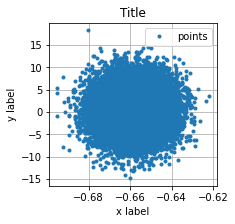

In [342]:
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(1,1,1)
ax.set_title("Title")
ax.set_xlabel("x label")
ax.set_ylabel("y label")
ax.grid()
ax.plot(DATA.T[0],DATA.T[1],ls="",marker=".",label="points")
ax.legend()

### 3D